## Rescale N, C, dC/dz

Since all our scaling is based of the squeezing/stretching of isopyncals and isoconcetration lines near the head, I moved the virtual station DnC to be close to the head (UwH for "upwelling near the head"). The sum of the max stratification above 100 m (rim?) and min stratification below 100 m correlates well with the upwelling flux $\Phi$. So , the stratification, and for that matter tracer gradient, that we want to scale is the one at the head and not at DnC (around mid length). In this notebook I rescale N above, N below, dC/dz above and below and C. 

In [1]:
#import gsw as sw # Gibbs seawater package

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [4]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh= 97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [5]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 

records = canyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_step** has all runs in records_dyn plus the runs with a step Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_kv** has all runs with step Kv profile. Use this list to fit N below for step Kv runs.

**records_nokv** has all runs except the ones with step Kv profile. Use this list to fit N below.

In [6]:
# Indices of all runs that will be consdered for paper 1

select_rec = [0,1,2,3,4,5,6,7,8,9,16,17,18,19,20,
              21,22,23,24,25,26,27,28,29,30,31,32,
              33,34,37,38,40,41,42,43,44,45,46,47,48]

In [7]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,6,7,8,9,16,17,18,19,20,21]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,6,7,8,9,16,17,18,19,20,21,28,32,37,38,44,45,46,47,48]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,6,7,8,9,16,17,18,19,20,21,28,29,30,31,32,
              33,34,37,38,40,41,42,43,44,45,46,47,48]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,1,2,3,4,5,6,7,8,9,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,33,34,40,41,42,43]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,6,7,8,9,16,17,18,19,21]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [8]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
   

In [9]:
keys2 = ['N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
    Nab_mean = 0
    Nbe_mean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.max(df[keys2[ii]][:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:23]) #20:24
        Nab_mean = Nab_mean + np.mean(df[keys2[ii]][:20]) #0:20
        Nbe_mean = Nbe_mean + np.mean(df[keys2[ii]][20:23]) #20:24
        
    records[ind].Nab = Nab/  len(keys2)
    records[ind].Nbe = Nbe/  len(keys2)
    records[ind].Nab_mean = Nab_mean / len(keys2)
    records[ind].Nbe_mean = Nbe_mean / len(keys2)
    

In [10]:
keys2 = ['dTrdz_tt16','dTrdz_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean = Nmean + np.mean(df[keys2[ii]][20:24])
        Nrim = Nrim + df[keys2[ii]][24]
    records[ind].dTr_ab = Nab/  len(keys2)
    records[ind].dTr_be = Nbe/  len(keys2)
    

In [11]:
keys2 = ['Tr_profile_tt16','Tr_profile_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean = Nmean + np.mean(df[keys2[ii]][20:24])
        Nrim = Nrim + df[keys2[ii]][24]
    records[ind].dTr_ab = Nab/  len(keys2)
    records[ind].dTr_be = Nbe/  len(keys2)


## Stratification

For Nmax+Nmin: slope = 12.88, intercept = -5.029, r-value = 0.933
For Nmean: slope = 10.34, intercept = -6.143, r-value = 0.957


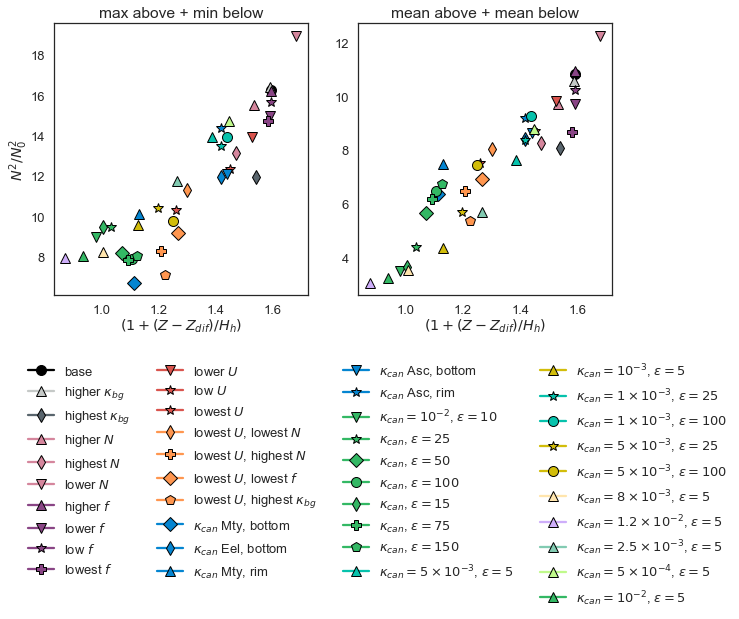

In [15]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_sel:
    
    Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*((rec.kv-rec.kbg)))/(rec.epsilon**0.1)
    
    rec.Z = Z
    rec.Zdif = Zdif
    
    plt1 = ax0.plot((1+(Z-Zdif)/Hh),(rec.Nbe+rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot((1+(Z-Zdif)/Hh),(rec.Nbe_mean+rec.Nab_mean)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
   

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'$(1+(Z-Z_{dif})/H_h)$',labelpad=0.5)
ax1.set_xlabel(r'$(1+(Z-Z_{dif})/H_h)$',labelpad=0.5)

ax0.set_title('max above + min below')
ax1.set_title('mean above + mean below')

Y0_array = np.array([(rec.Nbe+rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
X0_array = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_epsilon])
slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(X0_array,Y0_array)
print('For Nmax+Nmin: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope0, intercept0, r_value0))

Y1_array = np.array([(rec.Nbe_mean+rec.Nab_mean)**2/(rec.N**2) for rec in records_epsilon])
X1_array = np.array([1+(rec.Z-rec.Zdif)/Hh for rec in records_epsilon])
slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(X1_array,Y1_array)
print('For Nmean: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(slope1, intercept1, r_value1))


ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)

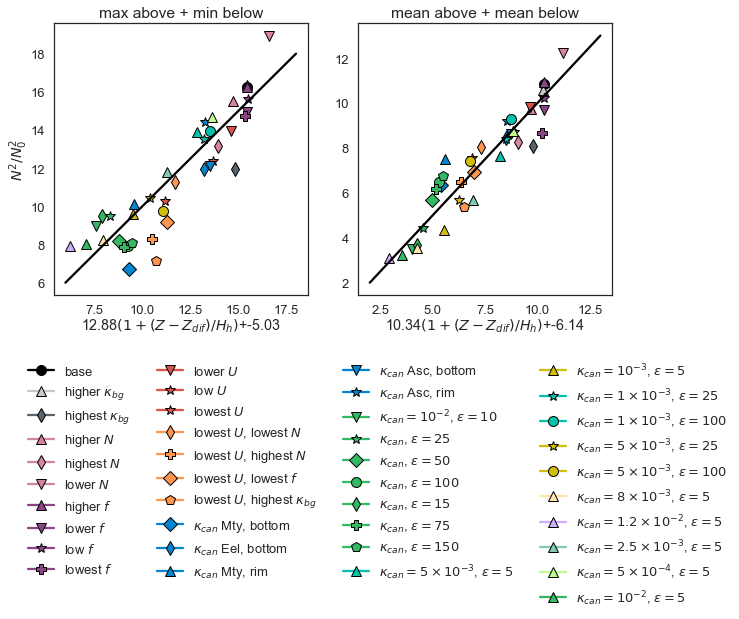

In [16]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (10,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

t=6.5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records_sel:

    plt1 = ax0.plot(slope0*(1+(rec.Z-rec.Zdif)/Hh)+intercept0,(rec.Nbe+rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
    plt1 = ax1.plot(slope1*(1+(rec.Z-rec.Zdif)/Hh)+intercept1,(rec.Nbe_mean+rec.Nab_mean)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 10,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=1.0,
                    markeredgecolor = 'k',
                    label=rec.label)
   

ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
ax0.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f' %(slope0, intercept0),labelpad=0.5)
ax1.set_xlabel(r'%1.2f$(1+(Z-Z_{dif})/H_h)$+%1.2f' %(slope1, intercept1),labelpad=0.5)

ax0.set_title('max above + min below')
ax1.set_title('mean above + mean below')


xx0 = np.linspace(6,18,50)
xx1 = np.linspace(2,13,50)

ax0.plot(xx0,xx0,'k-')
ax1.plot(xx1,xx1,'k-')

#mean_sq_err = np.mean(((maxN_array_Kv)-(4.10*tilt_array_Kv-3.00))**2)
#upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
#lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
#print('The rms error for N/No above is %f' %mean_sq_err)

#ax0.plot(np.linspace(0, 7.3, 50),np.linspace(0.0, 7.3, 50),'-', color='0.5')
#ax0.set_ylim(0.0,7.3)
#ax0.set_xlim(0.0,7.3)

#ax0.text(0.92,0.05,'(a)',transform=ax0.transAxes,fontsize=10)
#ax0.text(0.05,0.9,'$N^2$ max above rim',transform=ax0.transAxes,fontsize=10)
#ax0.set_aspect(1)
ax1.legend(bbox_to_anchor=(1.5,-0.2), ncol=4)
